In [ ]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [26]:
# 2. Đọc file csv và gắn index với giá AQI
df = pd.read_csv('/content/drive/MyDrive/Dataset/Test/HaNoi.csv')

In [27]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df = df[df['date'] < '2024-06-01']

In [28]:
# 10. Generate future predictions
def predict_future(model, data, time_step, future_days, scaler):
    temp_input = data[-time_step:].reshape(1, -1)
    temp_input = list(temp_input[0])
    future_output = []

    for _ in range(future_days):
        if len(temp_input) > time_step:
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, time_step, 1)
        prediction = model.predict(input_data, verbose=0)
        temp_input.append(prediction[0][0])
        future_output.append(prediction[0][0])

    future_output = scaler.inverse_transform(np.array(future_output).reshape(-1, 1))
    return future_output


In [29]:
# 5. Hàm Create Dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [30]:
def train_test_split_and_predict(tran_ratio=0.7):
  df1 = df.reset_index()['AQI']
# 3. Scaler data
  scaler = MinMaxScaler(feature_range=(0, 1))
  df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))
# 4. Chia train test
  train_size = int(tran_ratio * len(df1))
  test_size = len(df1) - train_size
  train_data = df1[:train_size]
  test_data = df1[train_size:]
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
  time_step = 100
  X_train, y_train = create_dataset(train_data, time_step)
  X_test, y_test = create_dataset(test_data, time_step)
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
  X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
  X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# 8. Define GRU Model
  model = Sequential()
  model.add(GRU(64, input_shape=(time_step, 1)))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
# 9. Fit mô hình với dữ liệu train
  model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

# Predict on train and test data
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

# Inverse transform predictions
  train_predict = scaler.inverse_transform(train_predict)
  test_predict = scaler.inverse_transform(test_predict)

# Predict for 30, 60, 90 days
  future_30_days = predict_future(model, df1, time_step, 30, scaler)
  future_60_days = predict_future(model, df1, time_step, 60, scaler)
  future_90_days = predict_future(model, df1, time_step, 90, scaler)
  plt.figure(figsize=(15, 8))

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 30), future_30_days, label="30 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 30 Days prediction')
  plt.legend()
  plt.show()

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 60), future_60_days, label="60 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 60 Days prediction')
  plt.legend()
  plt.show()

  # Plot train data
  plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot test data
  plt.plot(np.arange(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

    # Plot test predictions
  plt.plot(np.arange(len(train_data) + time_step, len(train_data) + time_step + len(test_predict)), test_predict, label='Test Predict')

    # Plot future predictions
  plt.plot(np.arange(len(df1), len(df1) + 90), future_90_days, label="90 Days Prediction")

    # Add labels and legend
  plt.xlabel('Days')
  plt.ylabel('AQI')
  plt.title(f'AQI Predictions - 90 Days prediction')
  plt.legend()
  plt.show()

# Calculate MAE, RMSE, and MAPE for test predictions
  mae = mean_absolute_error(y_test, test_predict)
  rmse = np.sqrt(mean_squared_error(y_test, test_predict))
  mape = mean_absolute_percentage_error(y_test, test_predict)

  print(f'MAE: {mae}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')


Epoch 1/100
30/30 [==============================] - 7s 123ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 3/100
30/30 [==============================] - 2s 62ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 5/100
30/30 [==============================] - 2s 63ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 6/100
30/30 [==============================] - 2s 63ms/step - loss: 0.0040 - val_loss: 0.0032
Epoch 7/100
30/30 [==============================] - 3s 92ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 8/100
30/30 [==============================] - 3s 98ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/100
30/30 [==============================] - 2s 64ms/step - loss: 0.0039 - val_loss: 0.0031
Epoch 10/100
30/30 [==============================] - 2s 63ms/step - loss: 0.0039 - val_loss: 0.003

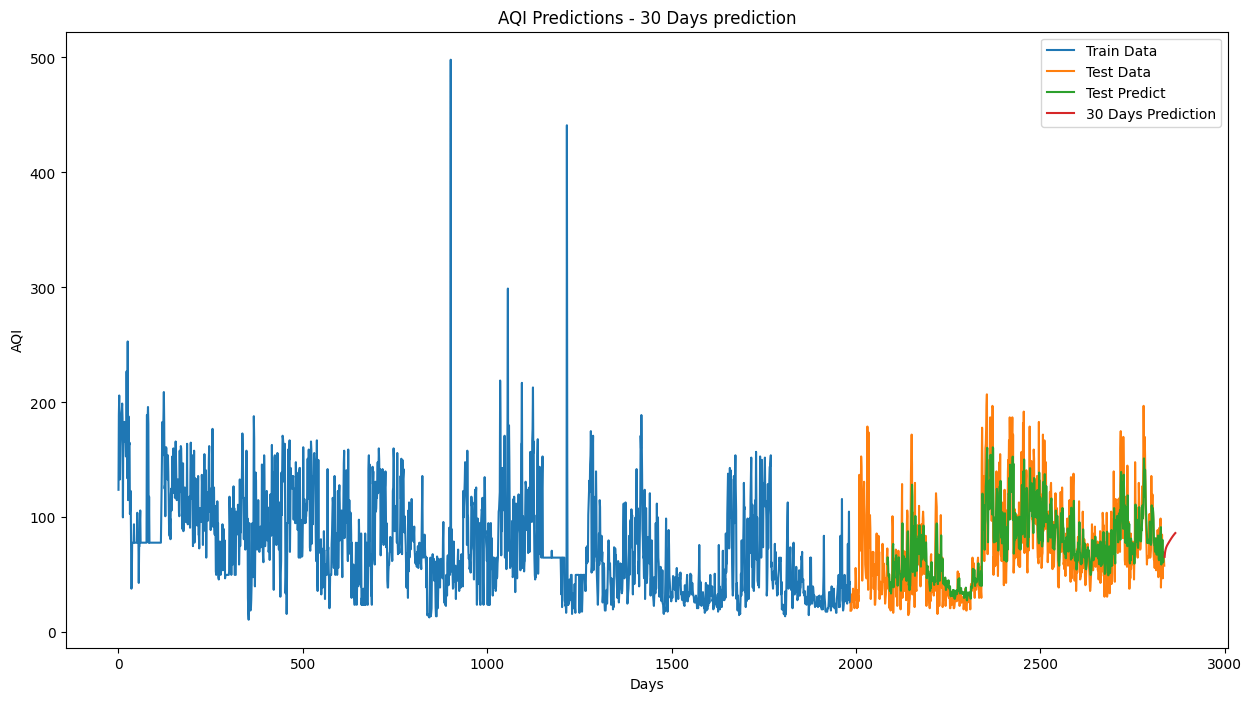

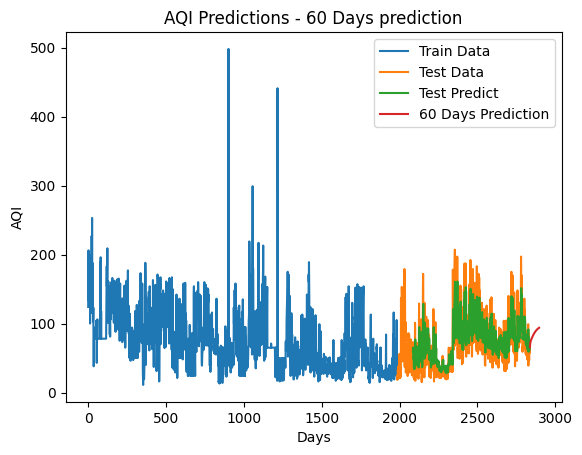

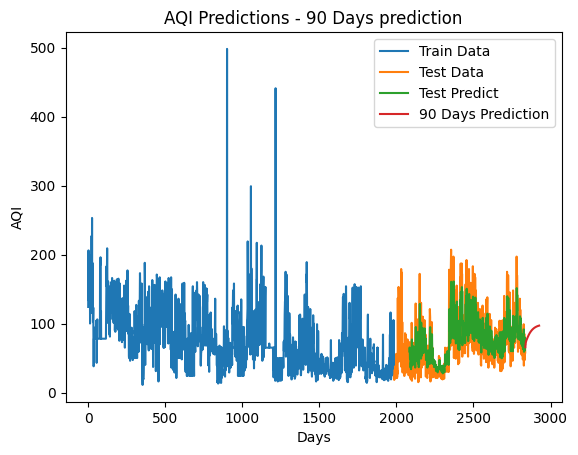

MAE: 76.35320369961386
RMSE: 81.263295254864
MAPE: 746.6995976583054
Epoch 1/100
34/34 [==============================] - 5s 78ms/step - loss: 0.0066 - val_loss: 0.0038
Epoch 2/100
34/34 [==============================] - 2s 62ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/100
34/34 [==============================] - 2s 62ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/100
34/34 [==============================] - 3s 81ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 5/100
34/34 [==============================] - 3s 94ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 6/100
34/34 [==============================] - 2s 64ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 7/100
34/34 [==============================] - 2s 63ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 8/100
34/34 [==============================] - 2s 61ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 9/100
34/34 [==============================] - 2s 61ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 10/100
34/34 [===========

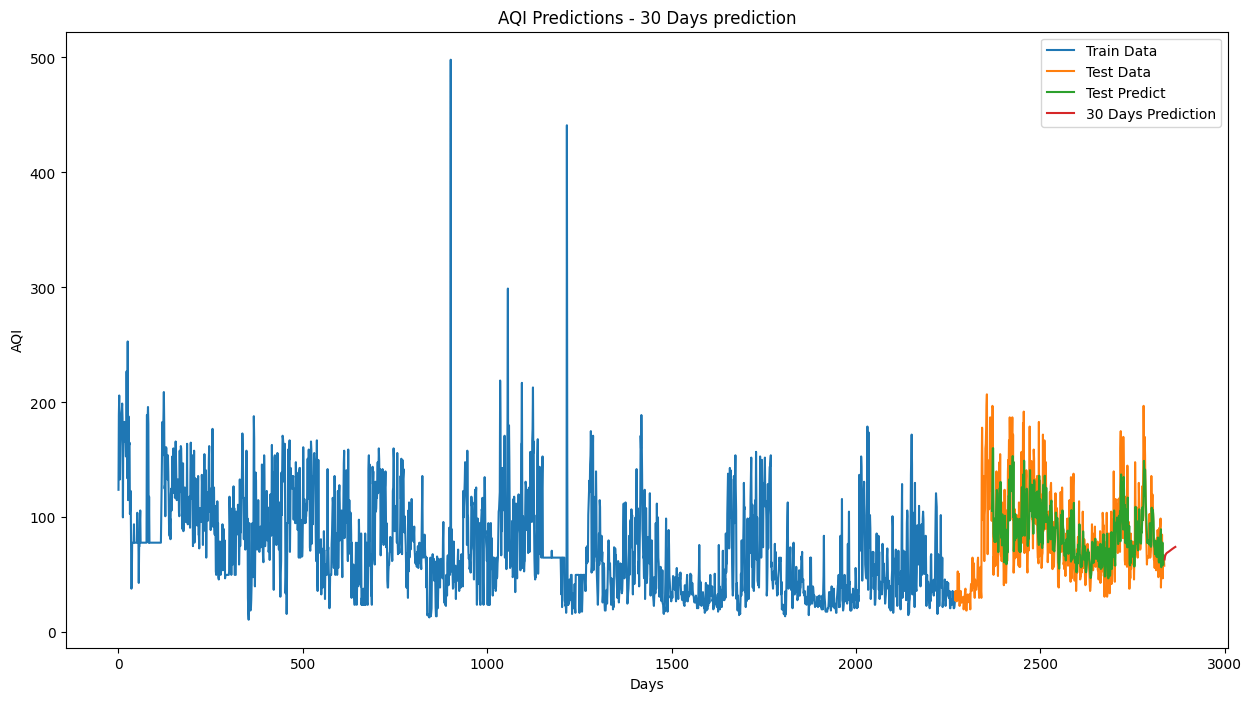

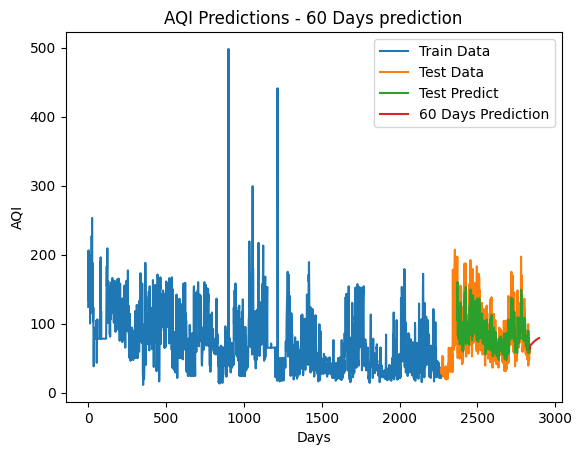

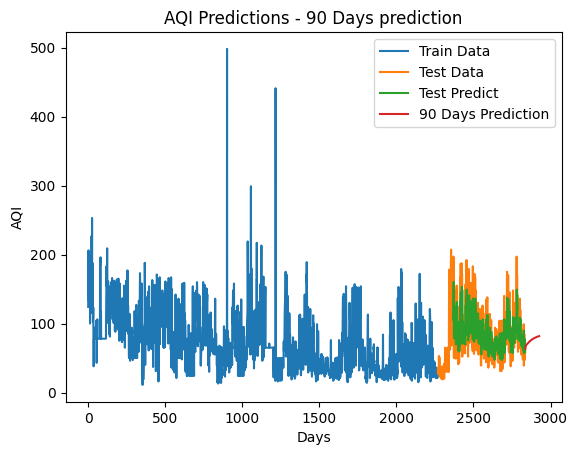

MAE: 86.02528804272185
RMSE: 88.87642410104854
MAPE: 627.1527194559765
Epoch 1/100
39/39 [==============================] - 5s 78ms/step - loss: 0.0085 - val_loss: 0.0034
Epoch 2/100
39/39 [==============================] - 3s 65ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 3/100
39/39 [==============================] - 3s 89ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 4/100
39/39 [==============================] - 4s 90ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 5/100
39/39 [==============================] - 3s 64ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 6/100
39/39 [==============================] - 3s 65ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 7/100
39/39 [==============================] - 3s 65ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 8/100
39/39 [==============================] - 3s 74ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 9/100
39/39 [==============================] - 4s 96ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 10/100
39/39 [=========

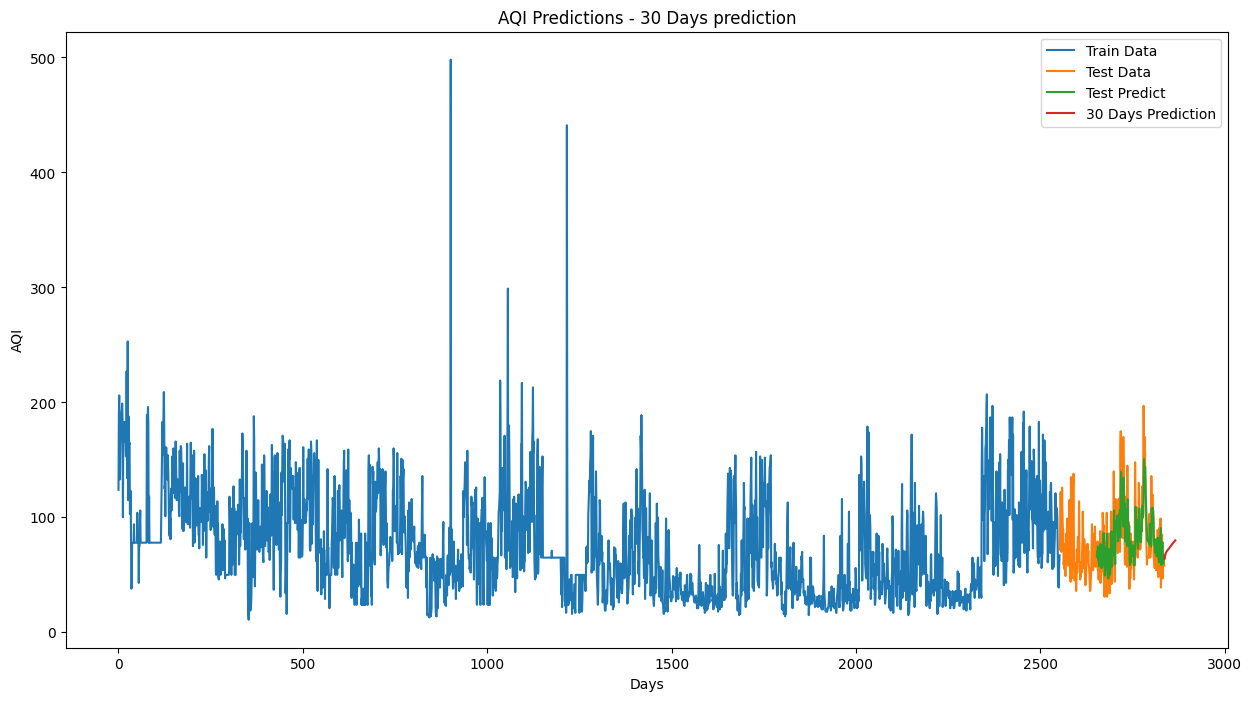

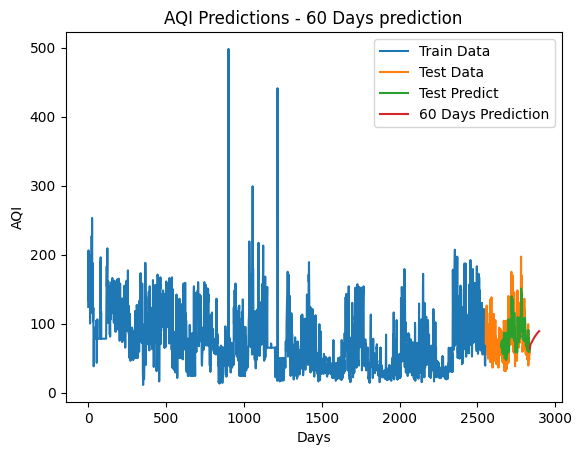

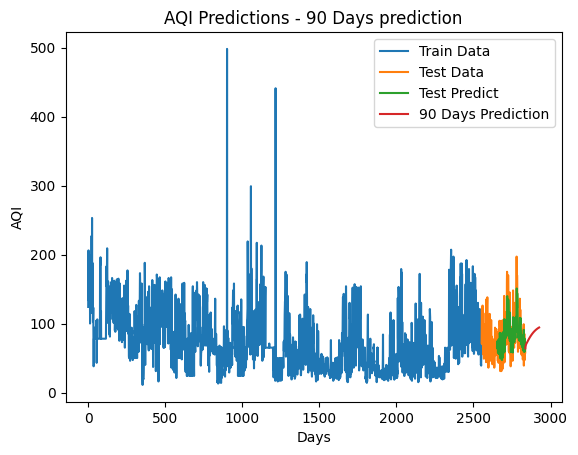

MAE: 82.38086022418011
RMSE: 84.89095927815306
MAPE: 642.779972778735


In [31]:
train_test_split_and_predict(0.7)
train_test_split_and_predict(0.8)
train_test_split_and_predict(0.9)